
##Homework 7: Implement LSTM

Groupmembers:
- Carmen Amme (994813)
- Anneke Büürma (995025)
- Wilfred Okajevo (998818)



# 2.1 Prepare the Dataset
To create the sequences you could simply .batch() twice, once to create the sequences and the second time to create the batches.

In [ ]:
# load packages
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime



Finding the targets

In [ ]:
def new_target_fnc(ds, sequence_len):
  """
  Creates list of new targets by alternately adding and subtracting
  The first digit is added, the second subtracted, the third added, etc
  Parameters
  ----------
  ds : TensorFlowDataset
  original mnist dataset containg images and targets as a tuple.
  sequence_len : int
  indicates at which point the sum has to reset for the new sequence
  Returns
  -------
  l : list
  list containing the new targets
  """

  l = list()
  for i, elem in enumerate(ds):
    if (i % sequence_len) == 0:
      l.append(int(elem[1]))
    else:
      if (i % 2) == 0:
        l.append(int(l[i-1] + elem[1]))
      else:
        l.append(int(l[i-1] - elem[1]))

  return l

In [ ]:
def new_targ(ds, sequence_len):
  #range_vals is only used to create the change between positive and negative signs for the summation
  range_vals = tf.range(10)
  #target_digits is a placeholder
  target_digits = tf.random.uniform((10,), minval=0, maxval=10, dtype=tf.dtypes.int32)
  #this creates the alternating positve and negative signes by checkign whether the entry index modulo 2 is zero (i.e. even entries are positive, uneven ones negative)
  #check the tf.where documentation if the usage is confusing for you!
  alternating_target_numbers = tf.where(tf.math.floormod(range_vals,2)==0, target_digits, -target_digits)
  print(alternating_target_numbers)
  #finally we can compute the cumulative sums!
  c_sum = tf.math.cumsum(alternating_target_numbers)
  print(c_sum)
  return c_sum

2.1.2 Create the datapipeline

In [ ]:
(train_ds, val_ds), ds_info = tfds.load ('mnist', split =['train', 'test'], as_supervised = True, with_info = True)

# print("ds_info: \n", ds_info)
# tfds.show_examples(train_ds, ds_info)

batch_size = 64
sequence_len = 6

def preprocess(dataset, batchsize, sequence_len):
    '''
    :param dataset: the dataset to be prepared for input into the network
    :param batchsize: the desired batchsize
    :param sequence_len: sequence the dataset (you may think this as a another batch)
    :return: sequenced dataset with sequential target
    '''

    # Step 1 - General Preprocessing

    # convert data from uint8 to float32
    dataset = dataset.map(lambda img, target: (tf.cast(img, tf.float32), target))

    # input normalization, just bringing image values from range [0, 255] to [-1, 1]
    dataset = dataset.map(lambda img, target: ((img / 128.) - 1., target))

    # The output of that lambda function should be a tuple of two tensors of shapes (num_images, height, width, 1) and (num_images, 1) or (num_images,)

    # Step 3 - Sequence Batching & Shuffling & Batching & Prefetching
    dataset = dataset.batch(sequence_len)

    # change the target

    # alternate positive, negative target values
    range_vals = tf.range(sequence_len)

    dataset = dataset.map(lambda img, target:
                          (img, tf.where(tf.math.floormod(range_vals,2)==0, target, -target)))

    dataset = dataset.map(lambda img, target:
                          (img, (tf.math.cumsum(target))))

    # cache
    dataset = dataset.cache()

    # shuffle, batch, prefetch
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batchsize)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    # The shape of your tensors should be (batch, sequence-length, features).
    return dataset

def expand_dimension(x, y):
    return x, tf.expand_dims(y, axis=-1)


train_ds = preprocess(train_ds, batch_size, 6)
val_ds = preprocess(val_ds, batch_size, 6)

train_ds = train_ds.map(expand_dimension)
val_ds = train_ds.map(expand_dimension)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
for img, label in train_ds.take(1):

  shape_ds = img.shape

  print(img.shape, label.shape) 
  # (bs, num_images, height, width, 1) (bs, num_images, 1)

(64, 6, 28, 28, 1) (64, 6, 1)


# 2.2 The CNN & LSTM Network

In [ ]:
# With extended batch shape [4, 7]:
input_shape = (64, 6, 28, 28, 1)
x = tf.random.normal(input_shape)
y = tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=input_shape[1:])(x)
print(y.shape)


(64, 6, 26, 26, 32)


In [ ]:
class BasicCNN_LSTM(tf.keras.Model):
    def __init__(self):
        super(BasicCNN_LSTM, self).__init__()

        self.convlayer1 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', 
                                                batch_input_shape=(batch_size, sequence_len, 28, 28, 1))#, input_shape=(28, 28, 1))
        self.convlayer2 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', 
                                                batch_input_shape=(batch_size, sequence_len, 28, 28, 1))#, input_shape=(28, 28, 1))
        self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', 
                                                batch_input_shape=(batch_size, sequence_len, 28, 28, 1))#, input_shape=(28, 28, 1))
        self.batchnorm1 = tf.keras.layers.BatchNormalization()

        self.global_pool = tf.keras.layers.GlobalAvgPool2D()
        self.timedist = tf.keras.layers.TimeDistributed(self.global_pool)

        self.rnn = tf.keras.layers.RNN(ourlstm(8), return_sequences=True) 
        self.batchnorm2 = tf.keras.layers.BatchNormalization()

        self.outputlayer = tf.keras.layers.Dense(units=1, activation=None) 
        
    @tf.function # Leon: comment it out when debugging
    def call(self, x):
        # print(f"initial shape: {x.shape}")
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.convlayer3(x)
        # print(f"shape after cnn: {x.shape}")
        
        x = self.batchnorm1(x)
        x = self.timedist(x) 
        # print(f"shape after timedist&pooling: {x.shape}") # shape should be (bs, sequence-length, features) before LSTM

        x = self.rnn(x)
        # print(f"shape after rnn: {x.shape}")
        
        x = self.batchnorm2(x)
        x = self.outputlayer(x)
        # print(f"shape after output: {x.shape}")

        return x

# 2.3 LSTM AbstractRNNCell layer

In [ ]:
class ourlstm(tf.keras.layers.AbstractRNNCell):

    def __init__(self, units, **kwargs): # units = units of the weight matrixs in each dense layer = units of the output
        super().__init__(**kwargs)

        self.units = units

        self.forgetgate = tf.keras.layers.Dense(units, 
                                                kernel_initializer=tf.keras.initializers.Orthogonal(gain=1.0, seed=None), 
                                                activation='sigmoid')
        self.inputgate1 = tf.keras.layers.Dense(units, 
                                                kernel_initializer=tf.keras.initializers.Orthogonal(gain=1.0, seed=None), 
                                                activation='sigmoid')
        self.inputgate2 = tf.keras.layers.Dense(units, 
                                                kernel_initializer=tf.keras.initializers.Orthogonal(gain=1.0, seed=None), 
                                                activation='tanh')
        self.outputgate = tf.keras.layers.Dense(units, 
                                                kernel_initializer=tf.keras.initializers.Orthogonal(gain=1.0, seed=None), 
                                                activation='sigmoid')
    
    @property
    def state_size(self):
        return [tf.TensorShape([self.units]), 
                tf.TensorShape([self.units])]
    @property
    def output_size(self):
        return [tf.TensorShape([self.units])]
    
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return [tf.zeros([batch_size, self.units]), 
                tf.zeros([batch_size, self.units])]


    # The LSTM-cell layer’s call method should take one (batch of) feature vector(s) as its input, 
    # along with the ”states”, a list containing the different state tensors of the LSTM cell (cell state and hidden state!).
    def call(self, inputs, states):
        # unpack the states
        cell_s = states[0]
        hidden_s = states[1]

        concat_value = tf.concat([inputs, hidden_s], axis=-1) # Leon: or use a tuple

        x1 = self.forgetgate(concat_value)
        x1 = tf.math.multiply(x1, cell_s) # or use *

        x2 = self.inputgate1(concat_value)
        x3 = self.inputgate2(concat_value)

        x3 = tf.math.multiply(x2, x3)
        new_cell_s = tf.math.add(x1, x3)

        x4 = self.outputgate(concat_value)
        new_hidden_s = tf.math.multiply(x4, tf.math.tanh(new_cell_s))

        return new_hidden_s, (new_hidden_s, new_cell_s)
        # The returns should be the output of the LSTM, to be used to compute the model
        # output for this time-step (usually the hidden state), as well as a list containing
        # the new states (e.g. [new hidden state, new cell state])

    def get_config(self):
        return {"hidden_units": self.units}

Epoch 1/20
157/157 [==============================] - 20s 99ms/step - loss: 30.5991 - MAE: 4.3451 - val_loss: 19.3776 - val_MAE: 3.4625
Epoch 2/20
157/157 [==============================] - 14s 87ms/step - loss: 12.3192 - MAE: 2.6942 - val_loss: 9.5631 - val_MAE: 2.3615
Epoch 3/20
157/157 [==============================] - 14s 87ms/step - loss: 8.5475 - MAE: 2.2196 - val_loss: 7.5453 - val_MAE: 2.0780
Epoch 4/20
157/157 [==============================] - 15s 98ms/step - loss: 7.3435 - MAE: 2.0519 - val_loss: 7.2913 - val_MAE: 2.0411
Epoch 5/20
157/157 [==============================] - 14s 87ms/step - loss: 6.8828 - MAE: 1.9843 - val_loss: 6.3673 - val_MAE: 1.9010
Epoch 6/20
157/157 [==============================] - 12s 74ms/step - loss: 6.1611 - MAE: 1.8661 - val_loss: 5.7859 - val_MAE: 1.8014
Epoch 7/20
157/157 [==============================] - 14s 87ms/step - loss: 5.8480 - MAE: 1.8087 - val_loss: 5.4592 - val_MAE: 1.7519
Epoch 8/20
157/157 [==============================] - 14s 8

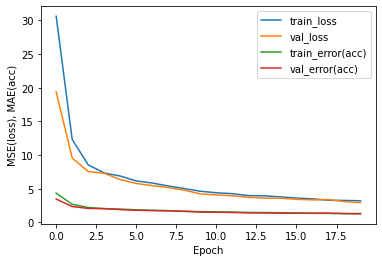

In [ ]:
epochs = 20
lr = 1e-2

mymodel = BasicCNN_LSTM()

loss = tf.keras.losses.MeanSquaredError()
opti = tf.keras.optimizers.Adam(learning_rate=lr)

mymodel.compile(loss=loss, 
                optimizer=opti, 
                metrics=['MAE']) # for accuracy - instead of tf.keras.metrics.MeanAbsoluteError()
                      
# save logs with Tensorboard
EXPERIMENT_NAME = "CNN_LSTM"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logging_callback = tf.keras.callbacks.TensorBoard(log_dir=f".myModel/{EXPERIMENT_NAME}/{current_time}")

history = mymodel.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[logging_callback])

# mymodel.load_weights(checkpoint_filepath)

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["MAE"])
plt.plot(history.history["val_MAE"])
plt.legend(labels=["train_loss","val_loss", "train_error(acc)", "val_error(acc)"])
plt.xlabel("Epoch")
plt.ylabel("MSE(loss), MAE(acc)")
plt.savefig(f"testing: e={epochs},lr={lr}.png")
plt.show()

# save configs (e.g. hyperparameters) of your settings
# checkpoint your model’s weights (or even the complete model
mymodel.save('/content/MyModel')
